In [19]:
%load_ext autoreload
%autoreload 2
from storytelling import *
from bert_extractive_summarizer.summarizer import Summarizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
word_embeddings = LoadWordEmbeddings(fil="../dat/glove/glove.twitter.27B.100d.txt")

In [20]:
datfile = "../dat/4884.csv.gz"
df = pd.read_csv(datfile, index_col="id")
df = df[df["rt_id"].isna()]
print(df.shape)

(148415, 11)


In [25]:
df1 = df[df["user_followers_count"]>10**5]
df1.shape

(4463, 11)

In [26]:
tids, row_sentences, clean_sentences = readsencence(df1)

In [27]:
print(len(tids), tids[:3])

3513 [476883063792615425, 476883152984481793, 476883174874968064]


In [28]:
sentence_vectors = Sentence2WE(clean_sentences, word_embeddings)
sentence_vectors
print(sentence_vectors.shape)

(3513, 100)


(3513, 40)


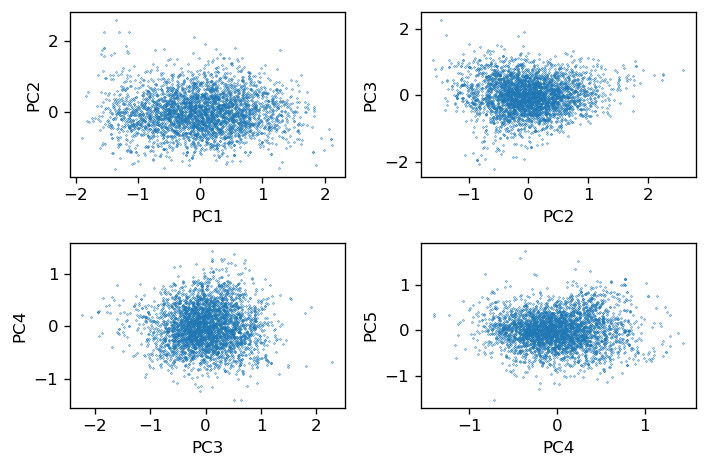

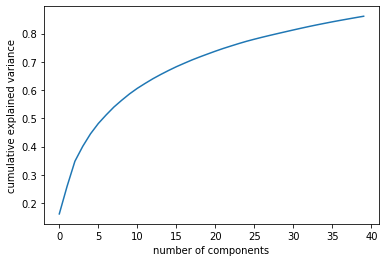

In [29]:
pca = PCA(n_components=40, svd_solver='arpack')
X = pca.fit_transform(sentence_vectors)
print(X.shape)
fig, axs = plt.subplots(2,2,dpi=120)
for i,(j,k) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axs[j,k].scatter(X[:,i], X[:,i+1], s=0.1)
    axs[j,k].set_xlabel("PC%d"%(i+1))
    axs[j,k].set_ylabel("PC%d"%(i+2))
fig.tight_layout()
plt.show()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [30]:
for nc, vexp in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if vexp > 0.8:
        NC = nc+1
        break
print(NC)

29


In [31]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(X[:, :NC])

In [32]:
Agg = sklearn.cluster.AgglomerativeClustering(distance_threshold=0.8, n_clusters=None, affinity="cosine",linkage="average")
clusters = Agg.fit_predict(X[:, :NC])
groups = AssignCluster(Y, clusters)
print(len(groups))

33


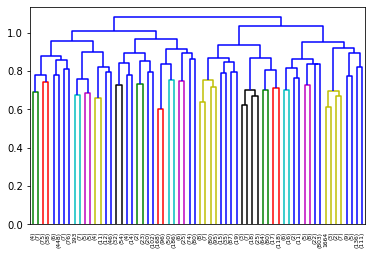

In [38]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(Agg, truncate_mode='level', p=5)

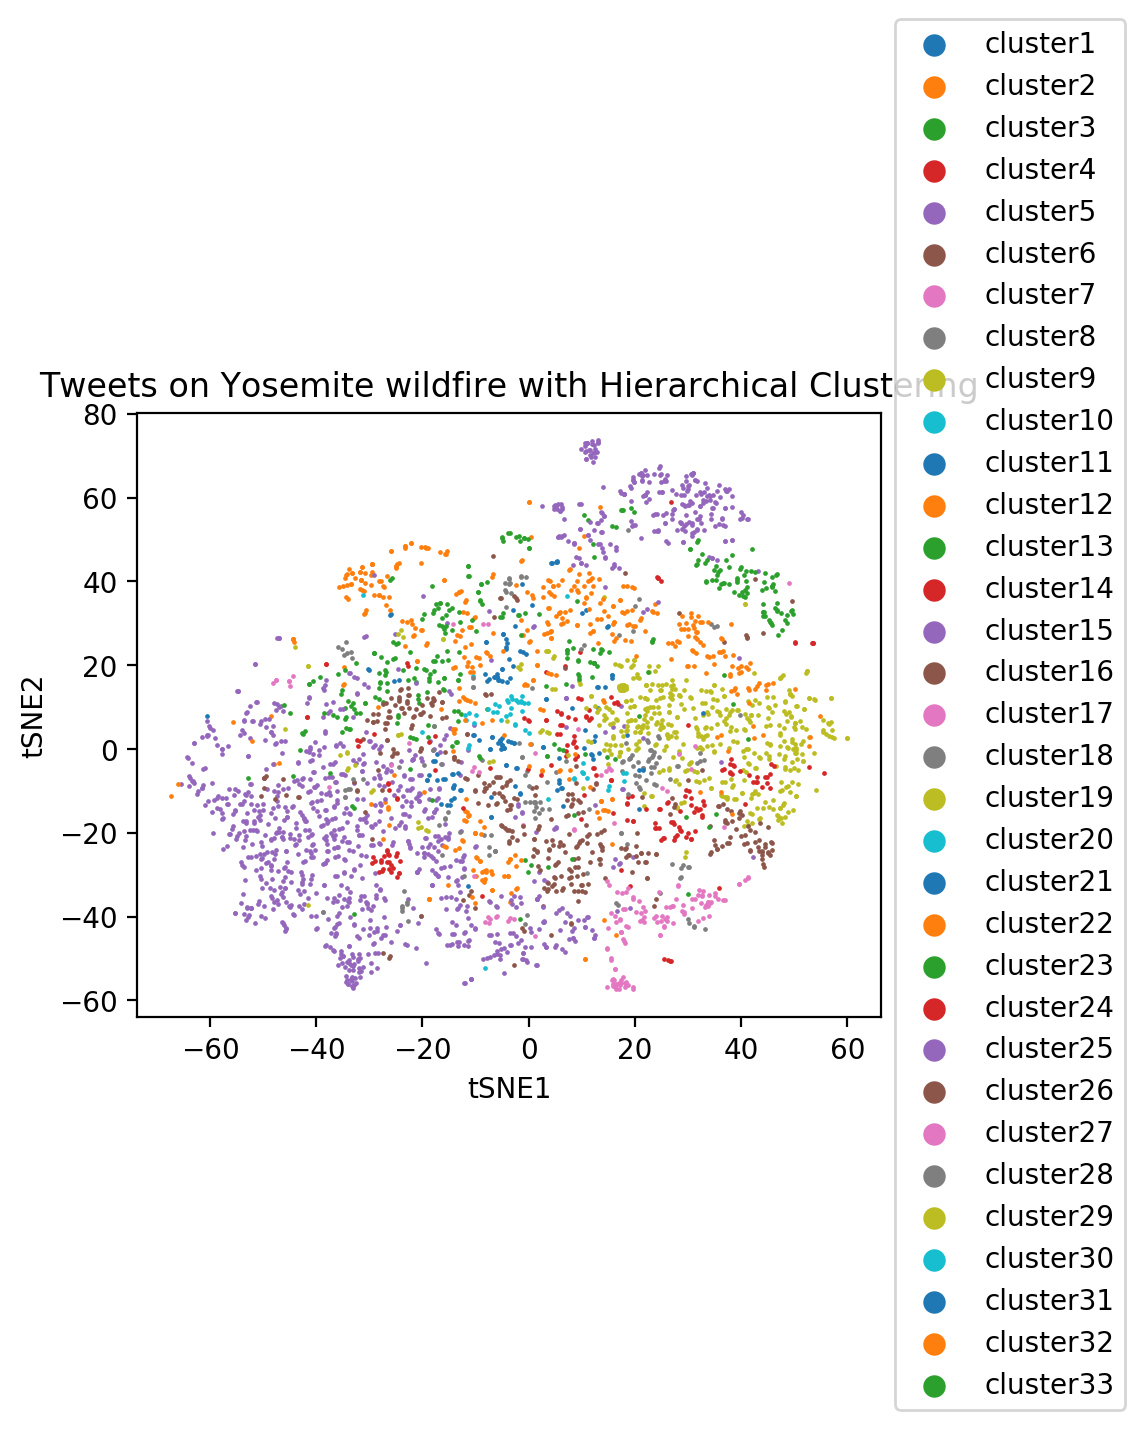

In [33]:
fig = plt.figure(dpi=200)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
#ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.title("Tweets on Yosemite wildfire with Hierarchical Clustering")
plt.show()

In [34]:
Totoal_art = []
for i in range(max(clusters)+1):
    topics = np.where(clusters==i)[0]
    if len(topics) < 5:
        continue
    topic_tweet_idxs = np.array([tids[int(i)] for i in topics])
    topic_sentence_vectors = np.array([sentence_vectors[int(i)] for i in topics])
    sim_mat = TextRankScoreMat(topic_sentence_vectors)
    threashold = 0.8
    rm_idx = []
    kept_idx = []
    for i in range(sim_mat.shape[0]):
        if i in rm_idx:
            continue
        kept_idx.append(i)
        for j in range(sim_mat.shape[1]):
            if sim_mat[i,j]>threashold:
                rm_idx.append(j)   
    #print(len(kept_idx))
    art = []
    selected_Clean = []
    for i in kept_idx:
        dat_id = topics[i]
        tid = tids[dat_id]
        date = datetime.strptime(df1.loc[tid, "created_at"],'%a %b %d %X %z %Y').strftime("%m-%d-%X")
        if len(row_sentences[dat_id]) > 20:
            art.append(row_sentences[dat_id])
            selected_Clean.append(clean_sentences[dat_id])
    #print(art)
    Totoal_art.append(".".join(art))
#print(Totoal_art)
print("\n".join(Totoal_art))

World Cup fever: A Dutch soccer fan drove nearly 13K miles from SF to Brazil in his '55 Chevy..Rio and Sao Paulo shine bright. worldcup.Brazil is angry. 13 powerful pictures of anti-Fifa WorldCup2014 graffiti.Eating and drinking in Sao Paulo during the WorldCup2014:.From USMNT camp in Sao Paulo  and  dicuss Klinsmann’s commentsJozy Altidore and Ghana (video):.Louis van Gaal’s new broom has Holland flying under radar in Brazil.Packeden route to the Arena de Sao Paulo. It's noon  Luz Station.Just hours before kick-off in Sao Paulochaos in enveloping the city.The World Cup opening ceremony is underway in Sao PauloBrazilvia.In the latest Contra a Copawe visit a pacified favela in Rio:.From Rio to Sao Paulosee the top Brazilian recommendations from fashion's finest -.The Statue of Christ in Rio Lights Up FifaWorldCupBrazil.Samba boys in full flow.My "welcoming party" outside Belo Horizonte hotel.Cometh the hourcometh Neymar - the man for Brazil: SAO PAULOJune 13 — Inevitably
The Stanley Cup

In [35]:
model = "bert-large-uncased"
hidden = -2
reduce_option = "mean"
model = Summarizer(
    model = model,
    hidden = hidden,
    reduce_option = reduce_option)

In [36]:
result = model("\n".join(Totoal_art), min_length=60)
print(result)

World Cup fever: A Dutch soccer fan drove nearly 13K miles from SF to Brazil in his '55 Chevy..Rio and Sao Paulo shine bright. Eating and drinking in Sao Paulo during the WorldCup2014:.From USMNT camp in Sao Paulo  and  dicuss Klinsmann’s commentsJozy Altidore and Ghana (video):.Louis van Gaal’s new broom has Holland flying under radar in Brazil. The World Cup opening ceremony is underway in Sao PauloBrazilvia. The 6 craziest requirements for FIFA WorldCup uniforms:.Anti-FIFA and WorldCup Protests - Live Blog 
Via  

NaoVaiTerCopa
Psychic Turtle Predicts World Cup Win For Brazil. Bjorn Kuiperswho once missed Luis Suarez biting an opponentto take referee England v Italy. 76.5% of WorldCup players make their professional careers in Europe:.Brazil has spent billions on the World Cupbut only about five hundred quid on the opening ceremony..Brazil 60% possessionCroatia 40%the ref 100%

ching
The New York Rangersby the numbers:.Pope Francis sends message to World Cup opening §RV.A Guide to t